In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import argparse
from dataclasses import dataclass
from datetime import datetime as dt
import json
import os
from pathlib import Path
from pprint import pprint
import sys
if '..' not in sys.path:
    sys.path.append('..')
import shutil
import traceback
from typing import Union, Any, Optional
import yaml

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch

from sdp.ds.bop_data import read_models_info, read_scene_camera, read_scene_gt, \
    read_scene_gt_info
from sdp.ds.bop_dataset import BopDataset
from sdp.ds.bop_dataset import AUGNAME_DEFAULT
from sdp.models.segmenter.factory import create_segmenter
from sdp.ds.emb_dataset import EmbDataset
from segm.optim.factory import create_optimizer, create_scheduler


ModuleNotFoundError: No module named 'mmseg.model'

In [ ]:
DATA_PATH = Path(os.path.expandvars('$HOME/data'))
BOP_PATH = DATA_PATH / 'bop'
ITODD_SUBDIR = 'itodd'
ITODD_BOP_PATH = BOP_PATH / ITODD_SUBDIR
print(f'BOP path: {BOP_PATH}')
TRAIN_ROOT_PATH = DATA_PATH / 'train_aae'

BOP path: /Users/misha/data/bop


In [5]:
ds = BopDataset.from_dir(BOP_PATH, ITODD_SUBDIR, shuffle=False)


Reading dataset from /Users/misha/data/bop/itodd/.sdp/v0.0.1


In [6]:
train_subdir = 'ds_itodd_obj_1_imsz_256_20231024_214603'
emb_ds = EmbDataset.read_cache(ds.get_cache_path() / train_subdir)

EmbDataset reading cache from /Users/misha/data/bop/itodd/.sdp/v0.0.1/ds_itodd_obj_1_imsz_256_20231024_214603


In [7]:
emb_ds.obj_ds_ids.shape, emb_ds.obj_ds_ids.dtype, emb_ds.embs.shape, emb_ds.embs.dtype

((16071,), dtype('int64'), (16071, 1000), dtype('float32'))

In [40]:
from scipy.spatial import KDTree
obj_ds_ids, embs, tcfg = emb_ds.obj_ds_ids, emb_ds.embs, emb_ds.tcfg
objs_view = ds.get_objs_view(tcfg.obj_id, keep_source_images=True, keep_cropped_images=True, return_tensors=False)
objs_view.set_out_size(tcfg.img_size)

min_mask_ratio: 20671 --> 18066
min_bbox_dim_ratio: 18066 --> 16071


In [27]:
kdt = KDTree(embs)

In [133]:
i1 = 58
x = embs[i1]
dists, inds = kdt.query(x, 2)
print(dists, inds)
i2 = inds[1]
print(np.linalg.norm(x - embs[i2]))
print(np.linalg.norm(embs[100:200] - x, axis=1))



[ 0.         42.32611845] [  58 2645]
42.32612
[74.39881  76.40772  65.55302  70.06283  72.15874  69.674164 70.48048
 66.81507  62.9812   59.538166 64.28871  70.8638   62.602036 68.54116
 77.40609  65.31119  64.267685 64.054474 60.455418 66.22199  65.226654
 78.394325 72.86584  73.44969  61.352867 63.94059  63.187195 67.69148
 73.00325  70.52474  68.04949  72.42677  73.2153   62.52341  72.90404
 71.219154 71.600525 71.98363  68.369156 70.74335  64.58688  58.00109
 68.98462  78.79125  61.730724 53.947315 66.07639  76.384766 68.56287
 71.09491  54.36137  76.783554 65.15134  68.93718  67.41266  61.362247
 73.169685 64.15816  75.87214  68.52457  63.230133 67.94625  71.329926
 76.72451  55.094494 71.93097  81.86362  64.41108  65.39853  72.400925
 68.00535  61.495003 62.35445  59.813786 77.09114  64.80024  71.03943
 64.75325  65.438705 85.98843  52.06211  59.462067 68.54495  54.42622
 73.41237  71.31757  67.979355 72.66466  62.44796  75.88655  75.691826
 66.74104  64.35421  53.77015  78.2398

In [138]:
x = embs[i1]
dx = np.linalg.norm(x)
i2, d2 = None, np.inf
for i, y in enumerate(embs):
    if i == i1: continue
    # dy = np.linalg.norm(y)
    # d = 1 - np.sum(x * y) / dx / dy
    d = np.linalg.norm(x - y)
    if d < d2:
        d2 = d
        i2 = i
        print(i, d)

0 75.986115
1 61.570377
11 57.111984
45 51.349003
481 51.011417
543 49.141457
663 48.11804
1077 47.03974
1884 46.0894
2645 42.32612


In [139]:
obj_ds_id1, obj_ds_id2 = obj_ds_ids[i1], obj_ds_ids[i2]

In [140]:
gt = objs_view.get_gt_imgs_masks([obj_ds_id1, obj_ds_id2], is_ids=True)

2


(<matplotlib.image.AxesImage at 0x7fdde20b8880>,
 <matplotlib.image.AxesImage at 0x7fdde20b91e0>)

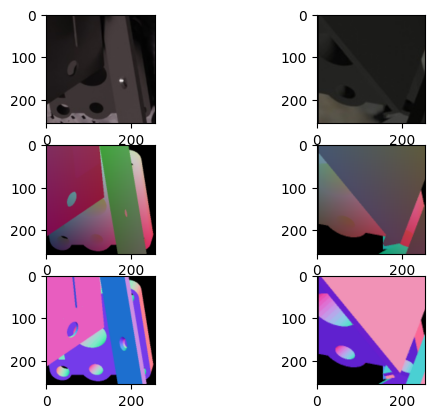

In [141]:
fig, axes = plt.subplots(3, 2)
print(len(gt.imgs_crop))
axes[0, 0].imshow(gt.imgs_crop[0]), axes[0, 1].imshow(gt.imgs_crop[1])
axes[1, 0].imshow(gt.maps_crop['noc'][0]), axes[1, 1].imshow(gt.maps_crop['noc'][1])
axes[2, 0].imshow(gt.maps_crop['norm'][0]), axes[2, 1].imshow(gt.maps_crop['norm'][1])


In [57]:
a, b = embs[0], embs[1]
print(a[:5])
print(b[:5])
print(a[:5] * b[:5])
print(np.sum(a[:5] * b[:5]))

[-0.9844052   1.5635394  -0.11677535 -1.1429964   1.2114443 ]
[-2.5216591   0.48855227 -0.58141154  0.5995235   2.9202297 ]
[ 2.4823344   0.7638707   0.06789453 -0.6852532   3.5376954 ]
6.166542


In [96]:
gt.df_obj

,img_ds_id,obj_ind,obj_id,px_count_all,px_count_valid,px_count_visib,visib_fract,R_m2c,t_m2c,bbox_obj_ltwh,bbox_visib_ltwh
obj_ds_id,,,,,,,,,,,
336745,13519,20,1,26006,22832,6302,0.242329,"[[0.37646564841270447, -0.9093555212020874, 0....","[-114.58218383789062, 100.21160888671875, 694....","[3.0, 839.0, 268.0, 155.0]","[77.0, 839.0, 194.0, 112.0]"
758233,30420,8,1,18891,18891,6097,0.322746,"[[-0.7743830680847168, 0.017663195729255676, 0...","[-61.78371810913086, -9.07906723022461, 861.41...","[333.0, 372.0, 176.0, 172.0]","[405.0, 391.0, 104.0, 153.0]"
